In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
stock = pd.read_csv("TSLA.csv" )
stock1 = stock[:]['Open']
stock = pd.read_csv("GOOGL.csv" )
stock2 = stock[:]['Open']
stock = pd.read_csv("DJI.csv" )
stock3 = stock[:]['Open']

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [4]:
scaler = MinMaxScaler()
stock1 = scaler.fit_transform(stock1.values.reshape(-1,1))
stock2 = scaler.fit_transform(stock2.values.reshape(-1,1))
stock3 = scaler.fit_transform(stock3.values.reshape(-1,1))

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [5]:
def load_data(stock, days):
    data = []
    for idx in range(len(stock) - days):
        data.append(stock[idx: idx + days])
    data = np.array(data)
    test_size = int(np.round(10 / 100 * data.shape[0]))
    train_size = data.shape[0] - test_size
    x_train = data[:train_size, :-1]
    y_train = data[:train_size, -1]
    x_test = data[train_size:, :-1]
    y_test = data[train_size:, -1]
    return [x_train, y_train, x_test, y_test]

# TesnorFlow Model

In [6]:
days = 20
steps = days - 1
learning_rate = 0.001
batch_size = 20
n_epochs = 50
n_inputs = 1
n_outputs = 1
n_neurons = 128
n_layers = 2

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, steps, n_outputs])[:, steps - 1, :]

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Training

In [8]:
x_train, y_train, x_test, y_test = load_data(stock1, days)
train_size = x_train.shape[0]
test_size = x_test.shape[0]
idx = 0
day_idx  = np.arange(x_train.shape[0])
np.random.shuffle(day_idx)

def next_batch(batch_size):
    global x_train, idx, day_idx
    start = idx
    idx += batch_size
    if idx > x_train.shape[0]:
        np.random.shuffle(day_idx)
        start = 0
        idx = batch_size
    end = idx
    return x_train[day_idx[start:end]], y_train[day_idx[start:end]]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(int(n_epochs*train_size/batch_size)):
        x_batch, y_batch = next_batch(batch_size)
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if i % int(10*train_size/batch_size) == 0:
            loss = loss.eval(feed_dict={X: x_train, y: y_train})
            print('epoch %.2f loss in train: %.6f'%(
                round(i*batch_size/train_size), loss))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

(2207, 20, 1)
epoch 0.00 loss in train: 0.128953
epoch 10.00 loss in train: 0.000458
epoch 20.00 loss in train: 0.000236
epoch 30.00 loss in train: 0.000222
epoch 40.00 loss in train: 0.000284


# Testing

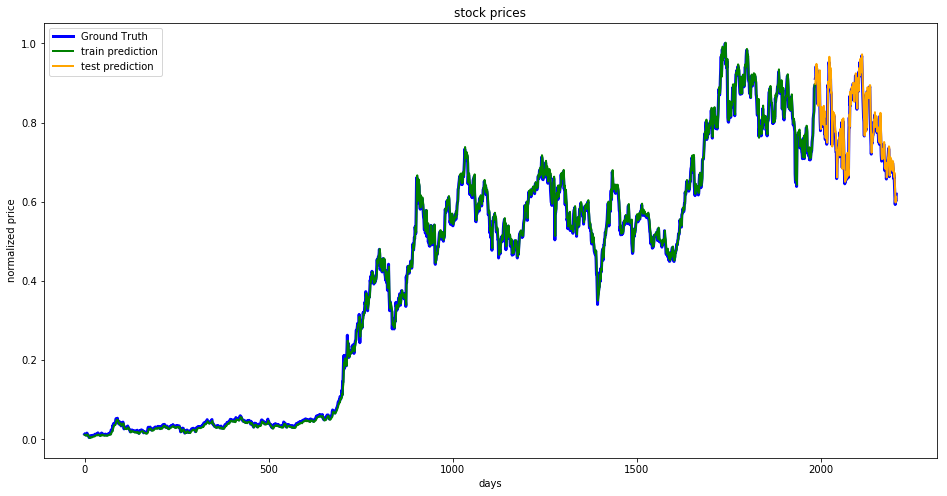

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(y_train.shape[0]), y_train[:,0], linewidth = '3', color='blue', label='Ground Truth')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,0], linewidth = '3', color='blue')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,0], linewidth = '2', color='green',label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,0], linewidth = '2', color='orange', label='test prediction')

plt.title('stock prices')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.legend(loc='best')

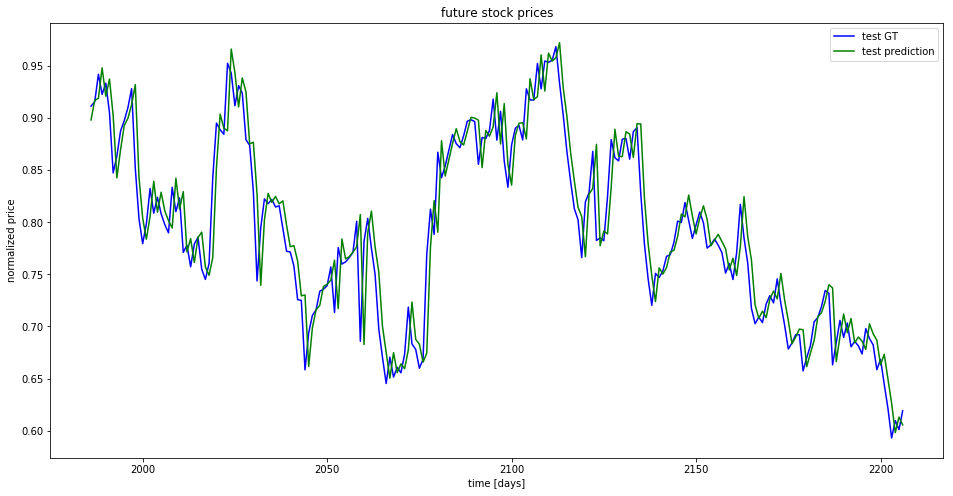

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,0], color='blue', label='test GT')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),y_test_pred[:,0], color='green', label='test prediction')

plt.title('stock prediction')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.legend(loc='best')

epoch 0.00 loss in train: 0.050552
epoch 10.00 loss in train: 0.000091
epoch 20.00 loss in train: 0.000045
epoch 30.00 loss in train: 0.000036
epoch 40.00 loss in train: 0.000032


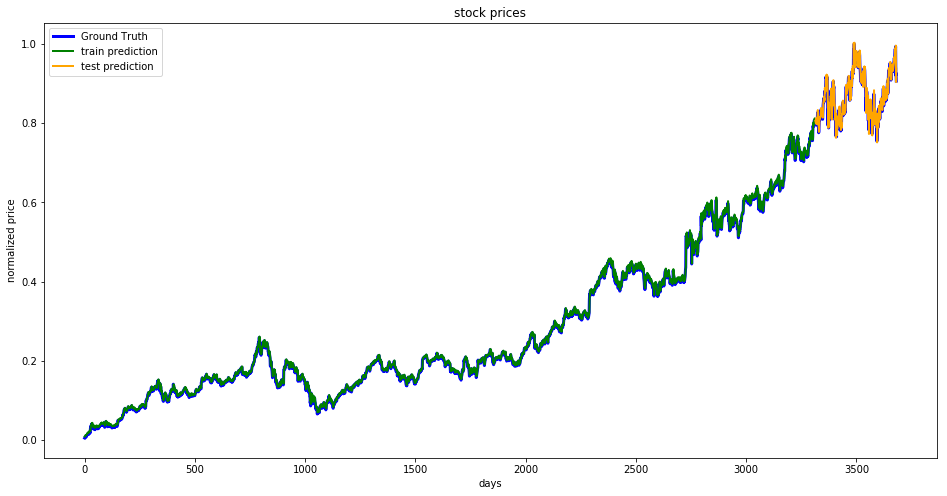

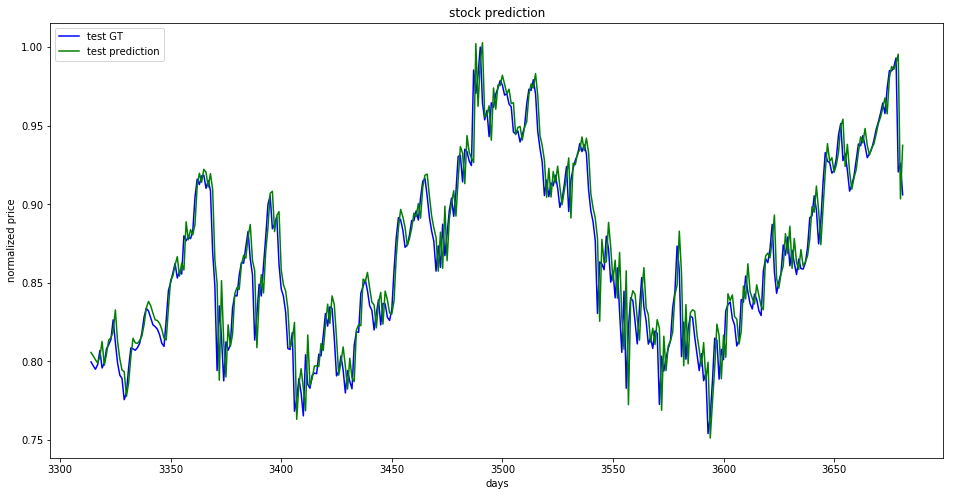

In [7]:
# Google
x_train, y_train, x_test, y_test = load_data(stock2, days)
train_size = x_train.shape[0]
test_size = x_test.shape[0]
idx = 0
day_idx  = np.arange(x_train.shape[0])
np.random.shuffle(day_idx)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(int(n_epochs*train_size/batch_size)):
        x_batch, y_batch = next_batch(batch_size)
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if i % int(10*train_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            print('epoch %.2f loss in train: %.6f'%(
                round(i*batch_size/train_size), mse_train))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
plt.figure(figsize=(16, 8))
plt.plot(np.arange(y_train.shape[0]), y_train[:,0], linewidth = '3', color='blue', label='Ground Truth')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,0], linewidth = '3', color='blue')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,0], linewidth = '2', color='green',label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,0], linewidth = '2', color='orange', label='test prediction')

plt.title('stock prices')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.legend(loc='best')

plt.figure(figsize=(16, 8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,0], color='blue', label='test GT')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),y_test_pred[:,0], color='green', label='test prediction')

plt.title('stock prediction')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.legend(loc='best')

epoch 0.00 loss in train: 0.043325
epoch 10.00 loss in train: 0.000026
epoch 20.00 loss in train: 0.000017
epoch 30.00 loss in train: 0.000020
epoch 40.00 loss in train: 0.000018


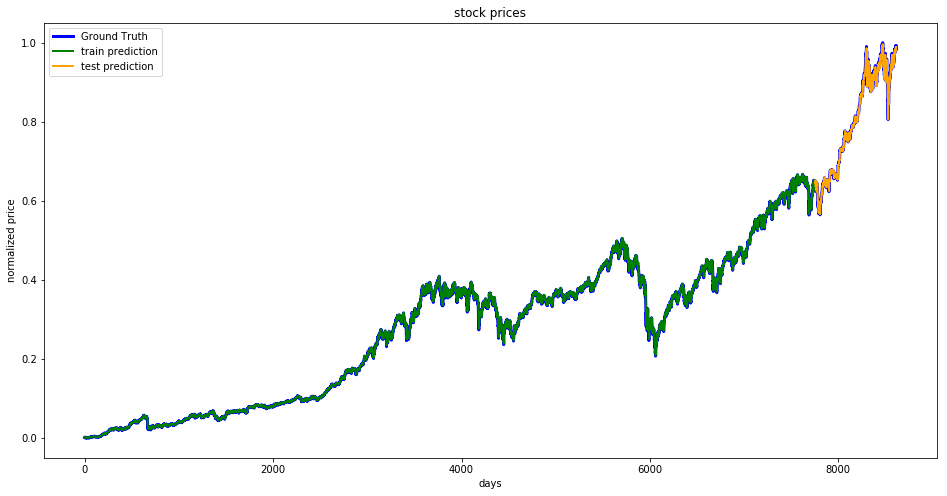

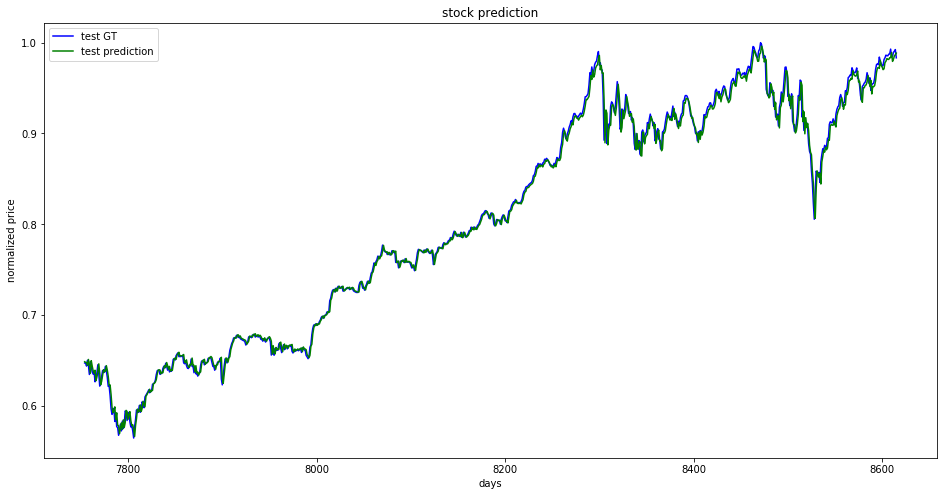

In [8]:
# DJI
x_train, y_train, x_test, y_test = load_data(stock3, days)
train_size = x_train.shape[0]
test_size = x_test.shape[0]
idx = 0
day_idx  = np.arange(x_train.shape[0])
np.random.shuffle(day_idx)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(int(n_epochs*train_size/batch_size)):
        x_batch, y_batch = next_batch(batch_size)
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if i % int(10*train_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            print('epoch %.2f loss in train: %.6f'%(
                round(i*batch_size/train_size), mse_train))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
plt.figure(figsize=(16, 8))
plt.plot(np.arange(y_train.shape[0]), y_train[:,0], linewidth = '3', color='blue', label='Ground Truth')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,0], linewidth = '3', color='blue')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,0], linewidth = '2', color='green',label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,0], linewidth = '2', color='orange', label='test prediction')

plt.title('stock prices')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.legend(loc='best')

plt.figure(figsize=(16, 8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,0], color='blue', label='test GT')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),y_test_pred[:,0], color='green', label='test prediction')

plt.title('stock prediction')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.legend(loc='best')